# Desafio DataCamp
## Predicting Industrial Machine Downtime [Level 3]

Link do desafio: https://app.datacamp.com/learn/competitions/industrial-machine-level-3

## Enunciado
---

### 📖 Cenário
Você trabalha para um fabricante de componentes metálicos de alta precisão utilizados nos setores aeroespacial, automotivo e de dispositivos médicos. Sua empresa opera **três máquinas diferentes** no chão de fábrica, cada uma produzindo componentes de tamanhos variados. Minimizar o tempo de inatividade dessas máquinas é essencial para cumprir os prazos de produção.

Sua equipe quer adotar uma abordagem orientada por dados para prever o tempo de inatividade das máquinas, permitindo o planejamento de manutenção proativa, em vez de reagir somente após falhas. Para isso, sua empresa tem coletado dados operacionais ao longo de um ano, indicando se as máquinas estavam ou não em funcionamento em momentos específicos.

Neste terceiro nível, você irá desenvolver um modelo preditivo que pode ser combinado com dados operacionais em tempo real para identificar possíveis falhas nas máquinas.

### **💾 Os Dados**

A empresa armazenou os dados operacionais das máquinas em uma única tabela, disponível no arquivo `'data/machine_downtime.csv'`.

**Cada linha na tabela representa os dados operacionais de uma única máquina em um determinado dia:**

- **`"Date"`** - Data em que a leitura foi realizada.
- **`"Machine_ID"`** - Identificador único da máquina em questão.
- **`"Assembly_Line_No"`** - Identificador único da linha de montagem onde a máquina está localizada.
- **`"Hydraulic_Pressure(bar)"`**, **`"Coolant_Pressure(bar)"`**, **`"Air_System_Pressure(bar)"`** - Medições de pressão (em bar) em diferentes pontos da máquina.
- **`"Coolant_Temperature"`**, **`"Hydraulic_Oil_Temperature"`**, **`"Spindle_Bearing_Temperature"`** - Medições de temperatura (em Celsius) em diferentes partes da máquina.
- **`"Spindle_Vibration"`**, **`"Tool_Vibration"`**, **`"Spindle_Speed(RPM)"`** - Medições de vibração (em micrômetros) e velocidade de rotação da ferramenta e do eixo principal.
- **`"Voltage(volts)"`** - Tensão elétrica fornecida à máquina.
- **`"Torque(Nm)"`** - Torque gerado pela máquina.
- **`"Cutting(KN)"`** - Força de corte da ferramenta.
- **`"Downtime"`** - Indicador de se a máquina estava ou não inativa no dia em questão.

### 💪 Desafio

Crie um relatório que aborde o seguinte:

- Treine e avalie um modelo preditivo para prever falhas nas máquinas.
- Quais características do conjunto de dados são os preditores mais fortes para a falha da máquina?
- Suas previsões são mais precisas se você modelar cada máquina separadamente?

## Inicialização
---

Comando para instalar as bibliotecas: `pip install pandas numpy scikit-learn matplotlib seaborn`

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

**Observação**: Para rodar os blocos de código, é necessário ter todas essas bibliotecas instaladas.

## Leitura
---

In [2]:
data = pd.read_csv('data/machine_downtime.csv')
print(data.info()) # Mostra informações gerais sobre o DataFrame (número de linhas, colunas, tipos de dados e valores nulos)
print(data.head()) # Exibe as 5 primeiras linhas do DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         2500 non-null   object 
 1   Machine_ID                   2500 non-null   object 
 2   Assembly_Line_No             2500 non-null   object 
 3   Hydraulic_Pressure(bar)      2490 non-null   float64
 4   Coolant_Pressure(bar)        2481 non-null   float64
 5   Air_System_Pressure(bar)     2483 non-null   float64
 6   Coolant_Temperature          2488 non-null   float64
 7   Hydraulic_Oil_Temperature    2484 non-null   float64
 8   Spindle_Bearing_Temperature  2493 non-null   float64
 9   Spindle_Vibration            2489 non-null   float64
 10  Tool_Vibration               2489 non-null   float64
 11  Spindle_Speed(RPM)           2494 non-null   float64
 12  Voltage(volts)               2494 non-null   float64
 13  Torque(Nm)        

## Pré-processamento
---

### Verificar valores ausentes

In [3]:
print("Valores ausentes:\n", data.isnull().sum())

Valores ausentes:
 Date                            0
Machine_ID                      0
Assembly_Line_No                0
Hydraulic_Pressure(bar)        10
Coolant_Pressure(bar)          19
Air_System_Pressure(bar)       17
Coolant_Temperature            12
Hydraulic_Oil_Temperature      16
Spindle_Bearing_Temperature     7
Spindle_Vibration              11
Tool_Vibration                 11
Spindle_Speed(RPM)              6
Voltage(volts)                  6
Torque(Nm)                     21
Cutting(kN)                     7
Downtime                        0
dtype: int64


### Preencher valores ausentes
- `data.fillna`: Substitui valores ausentes.
- Para colunas numéricas, preenche com a média.
- `inplace=True`: Altera o DataFrame original.

In [4]:
data.fillna(data.mean(numeric_only=True), inplace=True)


### Codificar variáveis categóricas

As variáveis categóricas são aquelas que representam categorias ou rótulos em vez de valores numéricos, como:

- Exemplo: `['Vermelho', 'Azul', 'Verde']`

Muitos algoritmos de Machine Learning não conseguem trabalhar diretamente com esses valores categóricos, pois eles esperam dados numéricos como entrada. 

Por isso, **é necessário transformar essas categorias em números**. Isso é conhecido como codificação ("encoding").

- `LabelEncoder`: Converte variáveis categóricas em valores numéricos.
- `fit_transform`: Ajusta o codificador aos dados e realiza a transformação.
- `label_encoders`: Dicionário para armazenar os codificadores para cada coluna.

In [5]:
# Inicializar o dicionário de codificadores
label_encoders = {}

# lista com os nomes das colunas categóricas que precisam ser codificadas
categorical_columns = ['Machine_ID', 'Assembly_Line_No'] 

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le # Armazenar o encoder

**OBS:** 
- `Machine_ID`: Identificação de máquinas (ex.: ['M1', 'M2', 'M3']).
- `Assembly_Line_No`: Número da linha de montagem (ex.: ['Linha A', 'Linha B']).

### Separando variáveis
- `data.drop`: Remove as colunas `Date` e `Downtime` (não usadas como entrada no modelo) para formar as variáveis independentes (X).
- `y = data['Downtime']`: Define a variável dependente (alvo) como `Downtime`.

In [6]:
X = data.drop(columns=['Date', 'Downtime'])
y = data['Downtime']

### Escalonando os dados

Escalar os dados significa transformar os valores numéricos para que estejam em uma mesma escala. 

**Por que escalar?**
- Isso é feito para evitar que variáveis com valores maiores influenciem desproporcionalmente o modelo.
- Muitos algoritmos de aprendizado de máquina, como **Regressão Logística**, **Redes Neurais** e **SVM**, dependem de dados escalonados para alcançar um desempenho ideal.
- Variáveis com valores grandes podem dominar outras na otimização dos modelos.

#### Transformando os dados com `fit_transform()`

**Passo 1: `scaler.fit_transform(X)`**

O método fit_transform realiza dois processos:

- `fit(X)`:
    - Calcula a média (𝜇) e o desvio padrão (σ) de cada coluna no conjunto de dados X.
    - Esses valores são usados para padronizar os dados.
- `transform(X)`:
    - Aplica a fórmula da padronização em cada valor das colunas.
    - O resultado é um novo conjunto de dados escalado.

**Passo 2: Wrapping com pd.DataFrame**

`pd.DataFrame(..., columns=X.columns)`
- Depois da transformação, o resultado do `fit_transform` é um array NumPy.
- Para manter a estrutura do DataFrame original (incluindo os nomes das colunas), o código reconstrói um DataFrame com:
    - Os dados escalados (obtidos pelo `fit_transform`).
    - Os nomes das colunas originais (`columns=X.columns`).

In [7]:
scaler = StandardScaler() # Instanciando scaler. Os dados são padronizados p/ uma distribuição com média 0 e desvio padrão 1
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # pd.DataFrame converte os dados escalados de volta para um DataFrame, preservando os nomes das colunas

Ao final desse processo, `X` passa a conter as mesmas colunas do conjunto de dados original, mas agora os valores:
- Estão centrados em torno de 0.
- Têm desvio padrão igual a 1.

Isso garante que todas as variáveis numéricas tenham a mesma escala, o que evita que alguma coluna com valores muito grandes ou muito pequenos influencie desproporcionalmente o modelo.

### **Exemplo prático**
Se `X` antes da transformação fosse:

| Feature1 | Feature2 |
|----------|----------|
| 10       | 1000     |
| 20       | 1500     |
| 30       | 2000     |

Após a padronização, ele poderia se parecer com:

| Feature1   | Feature2   |
|------------|------------|
| -1.224745  | -1.224745  |
|  0.000000  |  0.000000  |
|  1.224745  |  1.224745  |

Aqui:
- `Feature1` e `Feature2` foram ajustadas para a mesma escala.
- Isso melhora a performance de modelos que dependem de escalas semelhantes para diferentes variáveis.

## Treinamento
----

### Divisão treino-teste


- `train_test_split`: Divide os dados em conjuntos de treino (80%) e teste (20%).
- `random_state=56`: Garante resultados reproduzíveis.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

### Treinamento do modelo

- `RandomForestClassifier`: Cria um modelo de floresta aleatória.
- `n_estimators=100`: Usa 100 árvores de decisão.
- `fit`: Ajusta o modelo aos dados de treino.

In [9]:
rf_model = RandomForestClassifier(random_state=56, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=56)

### Predição


O método `.predict()` é chamado no modelo treinado (`rf_model`). 

Esse método aceita dados no mesmo formato das features do treinamento (que no caso, já foram escalonados com o `StandardScaler` anteriormente), e faz previsões usando o conjunto de teste.

Ele faz previsões para os dados de entrada fornecidos (`X_test`), que são as features do conjunto de teste.
Retorna as previsões do modelo, ou seja, os valores de saída esperados para cada exemplo no conjunto de teste.

O resultado, que é uma lista (ou array) com os rótulos previstos, é armazenado na variável `y_pred`.

In [10]:
y_pred = rf_model.predict(X_test)

### Avaliação

- `classification_report`: Exibe métricas como precisão, recall e F1-score.
- `confusion_matrix`: Mostra a matriz de confusão (verdadeiros e falsos positivos/negativos).
- `accuracy_score`: Calcula a acurácia do modelo.

In [11]:
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("Acurácia:", accuracy_score(y_test, y_pred))

Relatório de Classificação:
                     precision    recall  f1-score   support

   Machine_Failure       0.99      0.98      0.99       251
No_Machine_Failure       0.98      0.99      0.99       249

          accuracy                           0.99       500
         macro avg       0.99      0.99      0.99       500
      weighted avg       0.99      0.99      0.99       500

Matriz de Confusão:
 [[247   4]
 [  2 247]]
Acurácia: 0.988


A matriz de confusão foi escolhida porque:

- Oferece insights claros e interpretáveis.
- Identifica padrões de erro.
- Ajuda a diagnosticar problemas em classificadores, especialmente em casos desbalanceados.

## Feature Importances
---

- `feature_importances`: Importância relativa de cada recurso no modelo.
- `np.argsort`: Ordena os índices das importâncias em ordem decrescente.
- `sns.barplot`: Cria um gráfico de barras para exibir a importância.

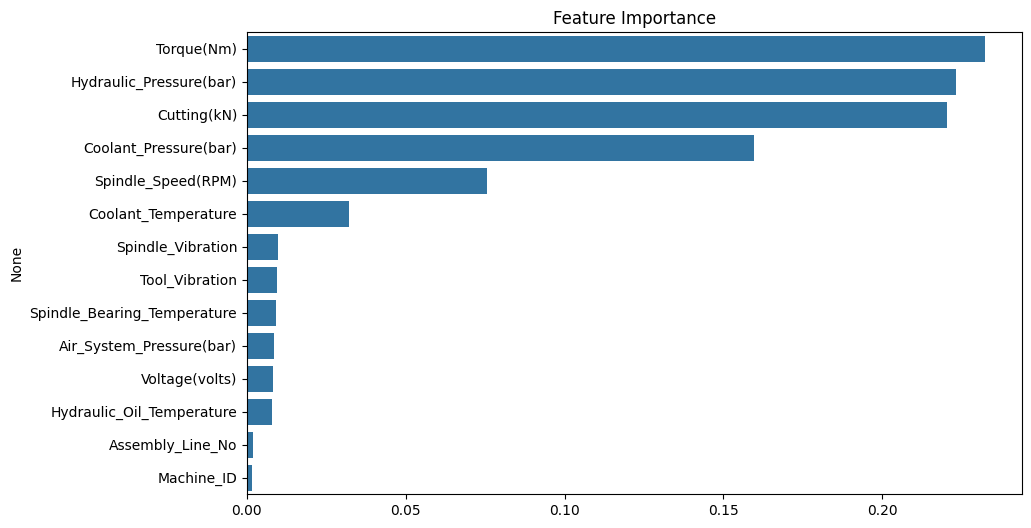

In [12]:
feature_importances = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[sorted_indices], y=X.columns[sorted_indices])
plt.title("Feature Importance")
plt.show()

## Modelagem por máquina
---


O código repete o processo de modelagem e avaliação, mas separadamente para cada máquina (`Machine_ID`). 

Isso permite com que o comportamento de cada máquina seja analisado individualmente.

In [13]:
machines = data['Machine_ID'].unique()
# Modelando cada máquina separadamente
for machine in machines:
    print(f"Modelagem para o ID da Máquina: {machine}")
    machine_data = data[data['Machine_ID'] == machine]
    X_machine = machine_data.drop(columns=['Date', 'Downtime'])
    y_machine = machine_data['Downtime']
    
    # Escalar dados
    X_machine = pd.DataFrame(scaler.fit_transform(X_machine), columns=X_machine.columns)

    # Train-test split
    X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_machine, y_machine, test_size=0.2, random_state=42)

    # Treinar e avaliar modelo
    rf_model.fit(X_train_m, y_train_m)
    y_pred_m = rf_model.predict(X_test_m)
    print("Relatório de Classificação:\n", classification_report(y_test_m, y_pred_m))
    print("Matriz de Confusão:\n", confusion_matrix(y_test_m, y_pred_m))
    print("Acurácia:", accuracy_score(y_test_m, y_pred_m))


Modelagem para o ID da Máquina: 0
Relatório de Classificação:
                     precision    recall  f1-score   support

   Machine_Failure       0.97      0.97      0.97        97
No_Machine_Failure       0.96      0.96      0.96        78

          accuracy                           0.97       175
         macro avg       0.97      0.97      0.97       175
      weighted avg       0.97      0.97      0.97       175

Matriz de Confusão:
 [[94  3]
 [ 3 75]]
Acurácia: 0.9657142857142857
Modelagem para o ID da Máquina: 2
Relatório de Classificação:
                     precision    recall  f1-score   support

   Machine_Failure       0.99      0.93      0.96        81
No_Machine_Failure       0.93      0.99      0.96        83

          accuracy                           0.96       164
         macro avg       0.96      0.96      0.96       164
      weighted avg       0.96      0.96      0.96       164

Matriz de Confusão:
 [[75  6]
 [ 1 82]]
Acurácia: 0.9573170731707317
Modelagem 